# Link Prediction : 7가지 = 동일한 커뮤니티 (그래프 전체), 다른 커뮤니티 (서로 다른 서브그래프들)
- [참고] https://brain-nim.tistory.com/m/76  

## 1. 하나의(동일한) community에서 링크를 예측하는 휴리스틱한 방법들 : Heuristics = CN, Jaccard, RA, AA, PA
- CN 에서 거리 2인 경로 구하는 과정만 추가되고, 이후의 계산은 모두 `networkx` 라이브러리 사용  
  
1. `CN (Common Neighbors)` : $CN(x,y)=|N(x)\cap N(y)|$  
  
2. `Jaccard Coefficient` : $J(x,y)=\frac{|N(x)\cap N(y)|}{|N(x)\cup N(y)|}$  
  
3. `RA (Resource Allocation)` : $RA(x,y)=\sum_{v\in N(x)\cap N(y)}\frac{1}{|N(v)|}$  
  
4. `AA (Adamic-Adar Index)` : $AA(x,y)=\sum_{v\in N(x)\cap N(y)}\frac{1}{\log |N(v)|}$  
  
5. `PA (Preferential Attachment Model, Barabasi Albert Model)` : $PA(x,y)=|N(x)||N(y)|$  

### 1-0. 예제 그래프 만들기 : 하나의 커뮤니티만 다루기 때문에 그래프 전체를 생각 
- $G=(V,E),~~|V|=9,~~ |E|=12$  
  
- 나중에 Cora dataset 으로 만든 그래프 넣어서 실험하면 됨

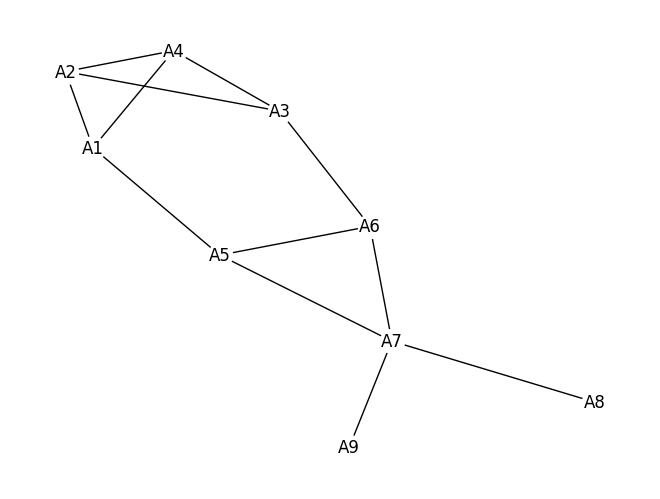

In [1]:
import networkx as nx

edges = [('A1','A2'), ('A1','A4'), ('A1','A5'), ('A2','A4'), ('A2','A3'), ('A3','A4'), 
         ('A3','A6'), ('A5','A6'), ('A5','A7'), ('A6','A7'), ('A7','A8'), ('A7','A9')]
G = nx.Graph()
G.add_edges_from(edges)
nx.draw(G, with_labels=True, node_color='white')

### 1-1. `CN (Common Neighbors)`  
- $CN(x,y)=|N(x)\cap N(y)|$  
    where $x,y$ : nodes and $N(x), N(y)$ : neighborhoods of $x,y$ (respectively)  
  
- [예] $CN(A1,A3)=|\{A2,A4\}|=2$  
  
- 알고리즘 순서  
    a. 비연결 node pair 구하기  
  
    b. 거리 2인 경로 구하기  
    - 방법 : a 에서 구한 각 비연결 노드 pair에 대한 (1-hop) 이웃 노드를 거치면 거리 2인 경로  
    - `nx.common_neighbors(G, u, v)` where $G$ : undirected graph and $u,v$ : nodes  
    - https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.common_neighbors.html
  
    c. 각 node pair 마다 길이 2인 경로의 개수 세기

In [2]:
## (1) CN (Common Neighbors) 
#### 엣지 연결이 없는 노드쌍
non_edges = list(nx.non_edges(G))
print(non_edges)

[('A3', 'A5'), ('A3', 'A9'), ('A3', 'A7'), ('A3', 'A1'), ('A3', 'A8'), ('A6', 'A4'), ('A6', 'A9'), ('A6', 'A1'), ('A6', 'A2'), ('A6', 'A8'), ('A5', 'A4'), ('A5', 'A9'), ('A5', 'A8'), ('A5', 'A2'), ('A4', 'A9'), ('A4', 'A7'), ('A4', 'A8'), ('A9', 'A8'), ('A9', 'A2'), ('A9', 'A1'), ('A1', 'A8'), ('A1', 'A7'), ('A7', 'A2'), ('A2', 'A8')]


In [3]:
#### 길이 2인 경로 구하기 : 
CN = {}
for s,t in non_edges:
    print(s,t, list(nx.common_neighbors(G,s,t))) 
## A-C는 경로 2개라는 거임 -> 길이 2인 경로가 가장 많음 

A3 A5 ['A6']
A3 A9 []
A3 A7 ['A6']
A3 A1 ['A2', 'A4']
A3 A8 []
A6 A4 ['A3']
A6 A9 ['A7']
A6 A1 ['A5']
A6 A2 ['A3']
A6 A8 ['A7']
A5 A4 ['A1']
A5 A9 ['A7']
A5 A8 ['A7']
A5 A2 ['A1']
A4 A9 []
A4 A7 []
A4 A8 []
A9 A8 ['A7']
A9 A2 []
A9 A1 []
A1 A8 []
A1 A7 ['A5']
A7 A2 []
A2 A8 []


In [4]:
## (1) CN (Common Neighbors) 
# 엣지 연결이 없는 노드쌍
non_edges = list(nx.non_edges(G))
# print(non_edges)

# 공통이웃 수 count 딕셔너리 생성
common_neighbors_count = {}
for n1,n2 in non_edges:
    common_neighbors_count[(n1, n2)] = len(list(nx.common_neighbors(G, n1, n2)))
    # print(common_neighbors_count)
sorted(common_neighbors_count.items(), key=lambda x: x[1], reverse=True)

[(('A3', 'A1'), 2),
 (('A3', 'A5'), 1),
 (('A3', 'A7'), 1),
 (('A6', 'A4'), 1),
 (('A6', 'A9'), 1),
 (('A6', 'A1'), 1),
 (('A6', 'A2'), 1),
 (('A6', 'A8'), 1),
 (('A5', 'A4'), 1),
 (('A5', 'A9'), 1),
 (('A5', 'A8'), 1),
 (('A5', 'A2'), 1),
 (('A9', 'A8'), 1),
 (('A1', 'A7'), 1),
 (('A3', 'A9'), 0),
 (('A3', 'A8'), 0),
 (('A4', 'A9'), 0),
 (('A4', 'A7'), 0),
 (('A4', 'A8'), 0),
 (('A9', 'A2'), 0),
 (('A9', 'A1'), 0),
 (('A1', 'A8'), 0),
 (('A7', 'A2'), 0),
 (('A2', 'A8'), 0)]

### 1-2. `Jaccard Coefficient (- index, - similarity)`  
- $J(x,y)=\frac{|N(x)\cap N(y)|}{|N(x)\cup N(y)|}$  
  
- [예] $J(A1,A3)=\frac{|\{A2,A4\}|}{|\{A2,A4,A5,A6\}|}=\frac{2}{4}=0.5$  
  
- `nx.jaccard_coefficient(G, ebunch=None)`  where `ebunch` : iterable of node pairs, optional (default = None)  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.jaccard_coefficient.html#networkx.algorithms.link_prediction.jaccard_coefficient 

In [5]:
## (2) Jaccard
jaccard = list(nx.jaccard_coefficient(G))
print('unsorted jaccard index :\n%s' % jaccard)
jaccard = sorted(jaccard, key=lambda x: x[2], reverse=True)  
print('---------------------------------------------------')
# jaccard.sort(key=lambda x: x[2], reverse=True)  
# print('Jaccard = %s' % jaccard)
for u,v,j in jaccard:
    print(f"({u},{v}) -> {j}")#:.8f}")

unsorted jaccard index :
[('A3', 'A5', 0.2), ('A3', 'A9', 0.0), ('A3', 'A7', 0.16666666666666666), ('A3', 'A1', 0.5), ('A3', 'A8', 0.0), ('A6', 'A4', 0.2), ('A6', 'A9', 0.3333333333333333), ('A6', 'A1', 0.2), ('A6', 'A2', 0.2), ('A6', 'A8', 0.3333333333333333), ('A5', 'A4', 0.2), ('A5', 'A9', 0.3333333333333333), ('A5', 'A8', 0.3333333333333333), ('A5', 'A2', 0.2), ('A4', 'A9', 0.0), ('A4', 'A7', 0.0), ('A4', 'A8', 0.0), ('A9', 'A8', 1.0), ('A9', 'A2', 0.0), ('A9', 'A1', 0.0), ('A1', 'A8', 0.0), ('A1', 'A7', 0.16666666666666666), ('A7', 'A2', 0.0), ('A2', 'A8', 0.0)]
---------------------------------------------------
(A9,A8) -> 1.0
(A3,A1) -> 0.5
(A6,A9) -> 0.3333333333333333
(A6,A8) -> 0.3333333333333333
(A5,A9) -> 0.3333333333333333
(A5,A8) -> 0.3333333333333333
(A3,A5) -> 0.2
(A6,A4) -> 0.2
(A6,A1) -> 0.2
(A6,A2) -> 0.2
(A5,A4) -> 0.2
(A5,A2) -> 0.2
(A3,A7) -> 0.16666666666666666
(A1,A7) -> 0.16666666666666666
(A3,A9) -> 0.0
(A3,A8) -> 0.0
(A4,A9) -> 0.0
(A4,A7) -> 0.0
(A4,A8) -> 0

### 1-3. `RA, Resource Allocation (자원할당)`  
- $RA(x,y)=\sum_{v\in N(x)\cap N(y)}\frac{1}{|N(v)|}$  
  
- [예] $RA(A1,A3)=\frac{1}{|N(A2)|}+\frac{1}{|N(A4)|}=\frac{1}{3}+\frac{1}{3}=\frac{2}{3}=0.666\ldots$  
    - $N(A1)\cap N(A3)=\{A2,A4,A5\}\cap \{A2,A4,A6\}=\{A2,A4\}$  
  
- `resource_allocation_index(G, ebunch=None)`
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.resource_allocation_index.html

In [6]:
## (3) RA, 자원 할당
resource = list(nx.resource_allocation_index(G))
resource = sorted(resource, key=lambda x: x[2], reverse=True)
for u,v,r in resource:
    print(f"({u},{v}) -> {r}")

(A3,A1) -> 0.6666666666666666
(A3,A5) -> 0.3333333333333333
(A3,A7) -> 0.3333333333333333
(A6,A4) -> 0.3333333333333333
(A6,A1) -> 0.3333333333333333
(A6,A2) -> 0.3333333333333333
(A5,A4) -> 0.3333333333333333
(A5,A2) -> 0.3333333333333333
(A1,A7) -> 0.3333333333333333
(A6,A9) -> 0.25
(A6,A8) -> 0.25
(A5,A9) -> 0.25
(A5,A8) -> 0.25
(A9,A8) -> 0.25
(A3,A9) -> 0
(A3,A8) -> 0
(A4,A9) -> 0
(A4,A7) -> 0
(A4,A8) -> 0
(A9,A2) -> 0
(A9,A1) -> 0
(A1,A8) -> 0
(A7,A2) -> 0
(A2,A8) -> 0


### 1-4. `AA, Adamic Adar`  
- $AA(x,y)=\sum_{v\in N(x)\cap N(y)}\frac{1}{\log|N(v)|}$  
  
- [예] $RA(A1,A3)=\frac{1}{\log|N(A2)|}+\frac{1}{\log|N(A4)|}=\frac{1}{\log 3}+\frac{1}{\log 3}=1.820478\ldots$  
  
- `resource_allocation_index(G, ebunch=None)`  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.resource_allocation_index.html#networkx.algorithms.link_prediction.resource_allocation_index

In [7]:
## AA
aa = list(nx.adamic_adar_index(G))
aa = sorted(aa, key=lambda x: x[2], reverse=True)
for u,v,a in aa:
    print(f"({u},{v}) -> {a}")

(A3,A1) -> 1.8204784532536746
(A3,A5) -> 0.9102392266268373
(A3,A7) -> 0.9102392266268373
(A6,A4) -> 0.9102392266268373
(A6,A1) -> 0.9102392266268373
(A6,A2) -> 0.9102392266268373
(A5,A4) -> 0.9102392266268373
(A5,A2) -> 0.9102392266268373
(A1,A7) -> 0.9102392266268373
(A6,A9) -> 0.7213475204444817
(A6,A8) -> 0.7213475204444817
(A5,A9) -> 0.7213475204444817
(A5,A8) -> 0.7213475204444817
(A9,A8) -> 0.7213475204444817
(A3,A9) -> 0
(A3,A8) -> 0
(A4,A9) -> 0
(A4,A7) -> 0
(A4,A8) -> 0
(A9,A2) -> 0
(A9,A1) -> 0
(A1,A8) -> 0
(A7,A2) -> 0
(A2,A8) -> 0


### 1-5. `PA, Preferential Attachment, Barabasi Albert`
- $PA(x,y)=|N(x)||N(y)|$  
  
- [예] $PA(A1,A3)=|N(A1)||N(A3)|=3\times 3=9$  
  
- `preferential_attachment(G, ebunch=None)`  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.preferential_attachment.html#networkx.algorithms.link_prediction.preferential_attachment

In [8]:
## (5) PA 
pref = list(nx.preferential_attachment(G))
pref = sorted(pref, key=lambda x: x[2], reverse=True)
for u,v,p in pref:
    print(f"({u},{v}) -> {p}")

(A3,A7) -> 12
(A4,A7) -> 12
(A1,A7) -> 12
(A7,A2) -> 12
(A3,A5) -> 9
(A3,A1) -> 9
(A6,A4) -> 9
(A6,A1) -> 9
(A6,A2) -> 9
(A5,A4) -> 9
(A5,A2) -> 9
(A3,A9) -> 3
(A3,A8) -> 3
(A6,A9) -> 3
(A6,A8) -> 3
(A5,A9) -> 3
(A5,A8) -> 3
(A4,A9) -> 3
(A4,A8) -> 3
(A9,A2) -> 3
(A9,A1) -> 3
(A1,A8) -> 3
(A2,A8) -> 3
(A9,A8) -> 1


## 2. 서로 다른 커뮤니티에서의 링크 예측 
- `networkx` 라이브러리 이용해서 계산하면 되므로 그래프만 만들면 됨
### 2-0. 예제 그래프 만들기 : 하나의 그래프에서 서로 다른 두 커뮤니티(즉, 두 부분그래프)를 다룰 것임 -> 위와 같은 그래프인데, 두 서브그래프로 나눠서 다룸 
- `community0 = [A1,A2,A3,A4]`  
- `community1 = [A5,A6,A7,A8,A9]`

In [9]:
# community0 = ['A','B','C','D']
# community1 = ['E','F','G','H','I']
# labels = dict(zip(list(range(8)), community0 + community1))
# # print(list(range(0,4)), list(range(4,9)))
# print(labels)

- node coloring 참고 : https://choiseokwon.tistory.com/172

In [10]:
# import networkx as nx
# import matplotlib.pyplot as plt

# G = nx.Graph()
# G.add_edge(1,2, weight=5)
# G.add_edge(1,3, weight=6)
# G.add_edge(1,4, weight=2)
# G.add_edge(2,4, weight=1)
# G.add_edge(1,4, weight=0.5)
# pos = nx.spring_layout(G)
# nx.draw(G, pos, with_labels=True)
# labels = nx.get_edge_attributes(G, 'weight')
# print(labels)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

NodeDataView({'A1': {'community': 0}, 'A2': {'community': 0}, 'A4': {'community': 0}, 'A5': {'community': 1}, 'A3': {'community': 0}, 'A6': {'community': 1}, 'A7': {'community': 1}, 'A8': {'community': 1}, 'A9': {'community': 1}})

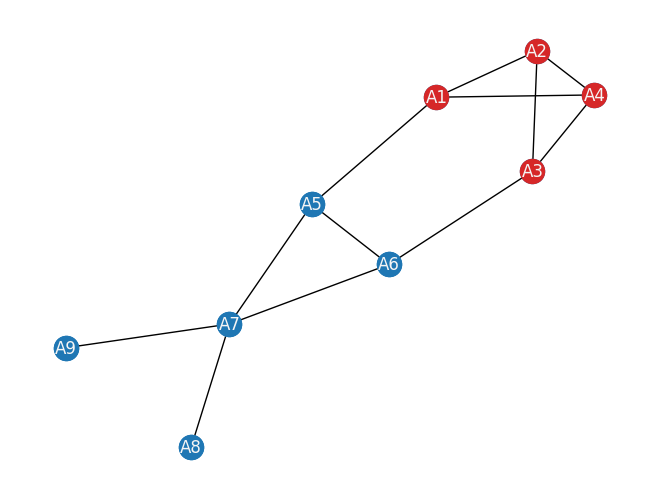

In [11]:
import networkx as nx

edges = [('A1','A2'), ('A1','A4'), ('A1','A5'), ('A2','A4'), ('A2','A3'), ('A3','A4'), 
         ('A3','A6'), ('A5','A6'), ('A5','A7'), ('A6','A7'), ('A7','A8'), ('A7','A9')] 
community0 = ['A1','A2','A3','A4'] ## 빨간색 노드
community1 = ['A5','A6','A7','A8','A9'] ## 파란색 노드

G = nx.Graph()
G.add_edges_from(edges) 
pos = nx.spring_layout(G, seed=2023) ## positions for all nodes 
nx.draw(G, pos=pos, with_labels=True, font_color="whitesmoke") 
nx.draw_networkx_nodes(G, pos, community0, node_color="tab:red")
nx.draw_networkx_nodes(G, pos, community1, node_color="tab:blue")
G.add_nodes_from(community0, community=0)
G.add_nodes_from(community1, community=1)
G.nodes(data=True)

### 2-1. `Community CN (C.N. Soundarajan-Hopcroft score)`
- "the common neighbors Soundarajan-Hopcroft score of nodes $x$ and $y$"
    - $CCN(x,y):=|N(x)\cap N(y)|+\sum_{v\in N(x)\cap N(y)}f(v)$, where $f(v)= 1$ if $v\in N(x)\cap N(y)$ and 0, otherwise  
  
    - 공통 이웃의 수 $=|N(x)\cap N(y)| = CN(x,y)$  
  
    - 공통 이웃이 같은 커뮤니티에 속하는지의 여부 $=\sum_{v\in N(x)\cap N(y)}f(v)$ 
  
- [예1] $CCN(A1,A3)=CN(A1,A3)+\sum_{v\in\{A2,A4\}}f(v)=|\{A2,A4\}|+(f(A2)+f(A4))=2+(1+1)=4$  
  
- [예2] $CCN(A6,A9)=CN(A6,A9)+\sum_{v\in\{A7\}}f(v)=|\{A7\}|+f(A7)=1+1=2$  
  
- `cn_soundarajan_hopcroft(G, ebunch=None, community='community')`  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.cn_soundarajan_hopcroft.html

In [12]:
cn_s_h = list(nx.cn_soundarajan_hopcroft(G))
cn_s_h = sorted(cn_s_h, key=lambda x: x[2], reverse=True)
for u,v,csh in cn_s_h:
    print(f"({u}, {v}) -> {csh}")

(A3, A1) -> 4
(A6, A9) -> 2
(A6, A8) -> 2
(A5, A9) -> 2
(A5, A8) -> 2
(A9, A8) -> 2
(A3, A5) -> 1
(A3, A7) -> 1
(A6, A4) -> 1
(A6, A1) -> 1
(A6, A2) -> 1
(A5, A4) -> 1
(A5, A2) -> 1
(A1, A7) -> 1
(A3, A9) -> 0
(A3, A8) -> 0
(A4, A9) -> 0
(A4, A7) -> 0
(A4, A8) -> 0
(A9, A2) -> 0
(A9, A1) -> 0
(A1, A8) -> 0
(A7, A2) -> 0
(A2, A8) -> 0


### 2-2. `Community RA (Community Resource Allocation)`
- "the Resource Allocation Soundarajan-Hopcroft score of nodes $x$ and $y$"
    - $CRA(x,y):=\sum_{v\in N(x)\cap N(y)}\frac{f(v)}{|N(v)|}$, where $f(v)= 1$ if $v\in N(x)\cap N(y)$ and 0, otherwise  
  
    - 기존 RA 와 비슷하나, 분자에 1 대신 $f(v)$ -> 커뮤니티에 속했는지의 여부도 헤아림 
  
- [예1] $CRA(A1,A3)=\sum_{v\in\{A2,A4\}}\frac{f(v)}{|N(v)|}=\frac{f(A2)}{|N(A2)|}+\frac{f(A4)}{|N(A4)|}=\frac{1}{3}+\frac{1}{3}=\frac{2}{3}=0.666\ldots$  
  
- [예2] $CRA(A6,A9)=\sum_{v\in\{A7\}}\frac{f(v)}{|N(v)|}=\frac{1}{4}=0.25$  
  
- `ra_index_soundarajan_hopcroft(G, ebunch=None, community='community')`  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.ra_index_soundarajan_hopcroft.html#networkx.algorithms.link_prediction.ra_index_soundarajan_hopcroft

In [13]:
ra_s_h = list(nx.ra_index_soundarajan_hopcroft(G))
ra_s_h = sorted(ra_s_h, key=lambda x: x[2], reverse=True)
for u,v,rsh in ra_s_h:
    print(f"({u}, {v}) -> {rsh}")

(A3, A1) -> 0.6666666666666666
(A6, A9) -> 0.25
(A6, A8) -> 0.25
(A5, A9) -> 0.25
(A5, A8) -> 0.25
(A9, A8) -> 0.25
(A3, A5) -> 0
(A3, A9) -> 0
(A3, A7) -> 0
(A3, A8) -> 0
(A6, A4) -> 0
(A6, A1) -> 0
(A6, A2) -> 0
(A5, A4) -> 0
(A5, A2) -> 0
(A4, A9) -> 0
(A4, A7) -> 0
(A4, A8) -> 0
(A9, A2) -> 0
(A9, A1) -> 0
(A1, A8) -> 0
(A1, A7) -> 0
(A7, A2) -> 0
(A2, A8) -> 0
